In [ ]:
%load_ext autoreload 
%autoreload 2
from utils.getDataFiles import *
from state.sleepScoring import *
from vip_helpers import *
from sleepscore import *
# 1. get rec paths
vip_data = load_vip_data()
animal='Back_left'
day = 'p9'
mainpath = f'/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}'
days = vip_data[f'day']
datapaths = [os.path.join(mainpath, day) for day in vip_data['day'] if os.path.exists(os.path.join(mainpath, day))]
test_path = os.path.join(mainpath, day)
test_datapaths = [mainpath for mainpath in datapaths if os.path.basename(mainpath) in ['p9', 'p12', 'p16', 'p19']]
dataclasses, state_dfs, s2p_outs, recordings = load_animal_data(animal)

# for path in datapaths:
#     try:
#         basename = os.path.basename(path)
#         sleep_state_ints, _ = get_state_intervals_df(path)
#         flattened_ints_df = flatten_state_ints_df(sleep_state_ints)
#         flattened_ints_df.to_parquet(os.path.join(path, f'{basename}_sleep_state_df.parquet'))
#     except:
#         continue

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
rename_all_dats(datapaths)
neuroscope_recday = 'p9'
#source_xml = os.path.join(mainpath, neuroscope_recday, f'{neuroscope_recday}.xml')
#copy_neuroscope_xml(source_xml, datapaths)

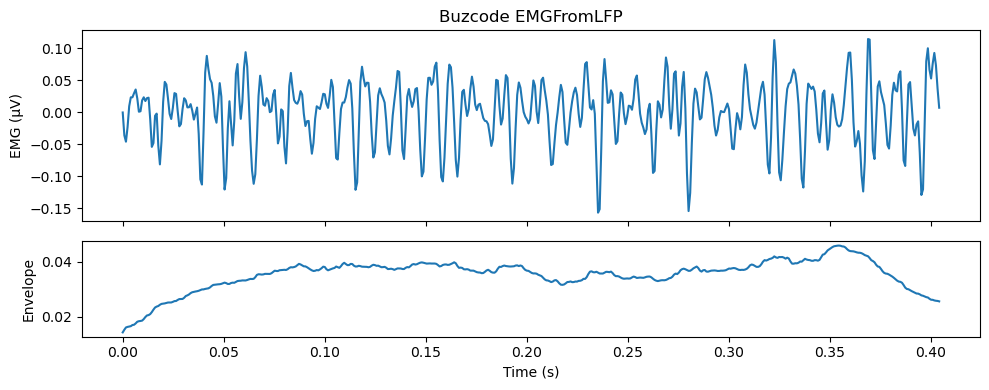

/tmp/ipykernel_3681212/4046818613.py:65: UserWarning: Only one segment is calculated since parameter NFFT (=512) >= signal length (=506).
  Pxx, freqs, bins, im = ax.specgram(emg_seg, NFFT=512, Fs=fs, noverlap=256)


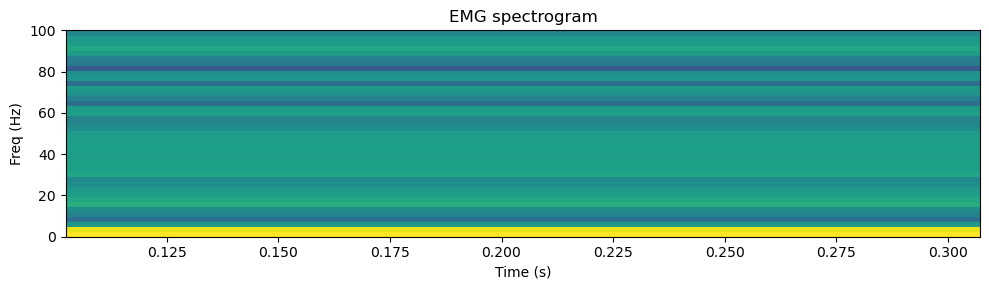

In [122]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def bandpass_filter(data, fs, lowcut=40, highcut=300, order=4):
    nyq = fs / 2.0
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")
    return filtfilt(b, a, data)

def emg_envelope(emg, fs, lowcut=40, highcut=300, smooth_ms=100):
    """
    EMG preprocessing:
    1) bandpass filter
    2) rectify
    3) smooth with moving average
    """
    # 1) bandpass
    emg_bp = bandpass_filter(emg, fs, lowcut=lowcut, highcut=highcut)
    # 2) rectify
    emg_rect = np.abs(emg_bp)
    # 3) smooth (moving average)
    win_samples = max(1, int(smooth_ms * 1e-3 * fs))
    win = np.ones(win_samples) / win_samples
    emg_env = np.convolve(emg_rect, win, mode="same")
    return emg_bp, emg_rect, emg_env


def plot_emg_trace(emg, fs, t_start=0, t_end=10, title=None):
    """
    Plot raw EMG + envelope for a time window [t_start, t_end] in seconds.
    """
    n = len(emg)
    t = np.arange(n) / fs

    # select window
    mask = (t >= t_start) & (t <= t_end)
    if not np.any(mask):
        raise ValueError("No samples in selected window")

    emg_bp, emg_rect, emg_env = emg_envelope(emg, fs)
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 4), height_ratios=[2, 1])

    # raw bandpassed EMG
    ax[0].plot(t[mask], emg_bp[mask])
    ax[0].set_ylabel("EMG (µV)")
    ax[0].set_title(title or f"EMG (bandpass) {t_start:.1f}–{t_end:.1f} s")

    # envelope
    ax[1].plot(t[mask], emg_env[mask])
    ax[1].set_ylabel("Envelope")
    ax[1].set_xlabel("Time (s)")

    plt.tight_layout()
    return fig, ax

def plot_emg_spectrogram(emg, fs, t_start=0, t_end=60):
    n = len(emg)
    t = np.arange(n) / fs
    mask = (t >= t_start) & (t <= t_end)
    emg_seg = emg[mask]

    fig, ax = plt.subplots(figsize=(10, 3))
    Pxx, freqs, bins, im = ax.specgram(emg_seg, NFFT=512, Fs=fs, noverlap=256)
    ax.set_ylim(0, 100)  # focus on EMG band
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Freq (Hz)")
    ax.set_title("EMG spectrogram")
    plt.tight_layout()
    return fig, ax

def load_buzcode_emg_fromlfp(mat_path):
    """
    Load Buzcode EMGFromLFP struct from EMGFROMLFP.LFP.mat.

    """
    import scipy
    #md = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    emg_from_lfp_file = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    if "EMGFromLFP" not in emg_from_lfp_file:
        raise KeyError(f"'EMGFromLFP' not found in {mat_path}. "
                        f"Top-level keys: {list(emg_from_lfp_file.keys())}")
    emg_from_lfp = emg_from_lfp_file["EMGFromLFP"]
    emg_signal = np.asarray(emg_from_lfp.data).squeeze()
    timestamps = np.asarray(emg_from_lfp.timestamps).squeeze()
    # emg_struct = md["EMGFromLFP"]
    # # Buzcode struct fields are usually .data and .samplingFrequency
    # data = np.asarray(emg_struct.data).squeeze()
    #emg_from_lfp = loadmat('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p9/p9.EMGFromLFP.LFP.mat')['EMGFromLFP']
    #emg_signal = emg_from_lfp[0]['data'][0].flatten()
    #timestamps = emg_from_lfp[0]['timestamps'][0].flatten()
    return emg_signal, timestamps
emg, timestamps = load_buzcode_emg_fromlfp('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p9/p9.EMGFromLFP.LFP.mat')
#print("lowcut, highcut:", lowcut, highcut)
fig, ax = plot_emg_trace(emg, 1250, t_start=0, t_end=11250,
                         title="Buzcode EMGFromLFP")
plt.show()
fig, ax = plot_emg_spectrogram(emg, 1250, t_start=0, t_end=11250)
plt.show()

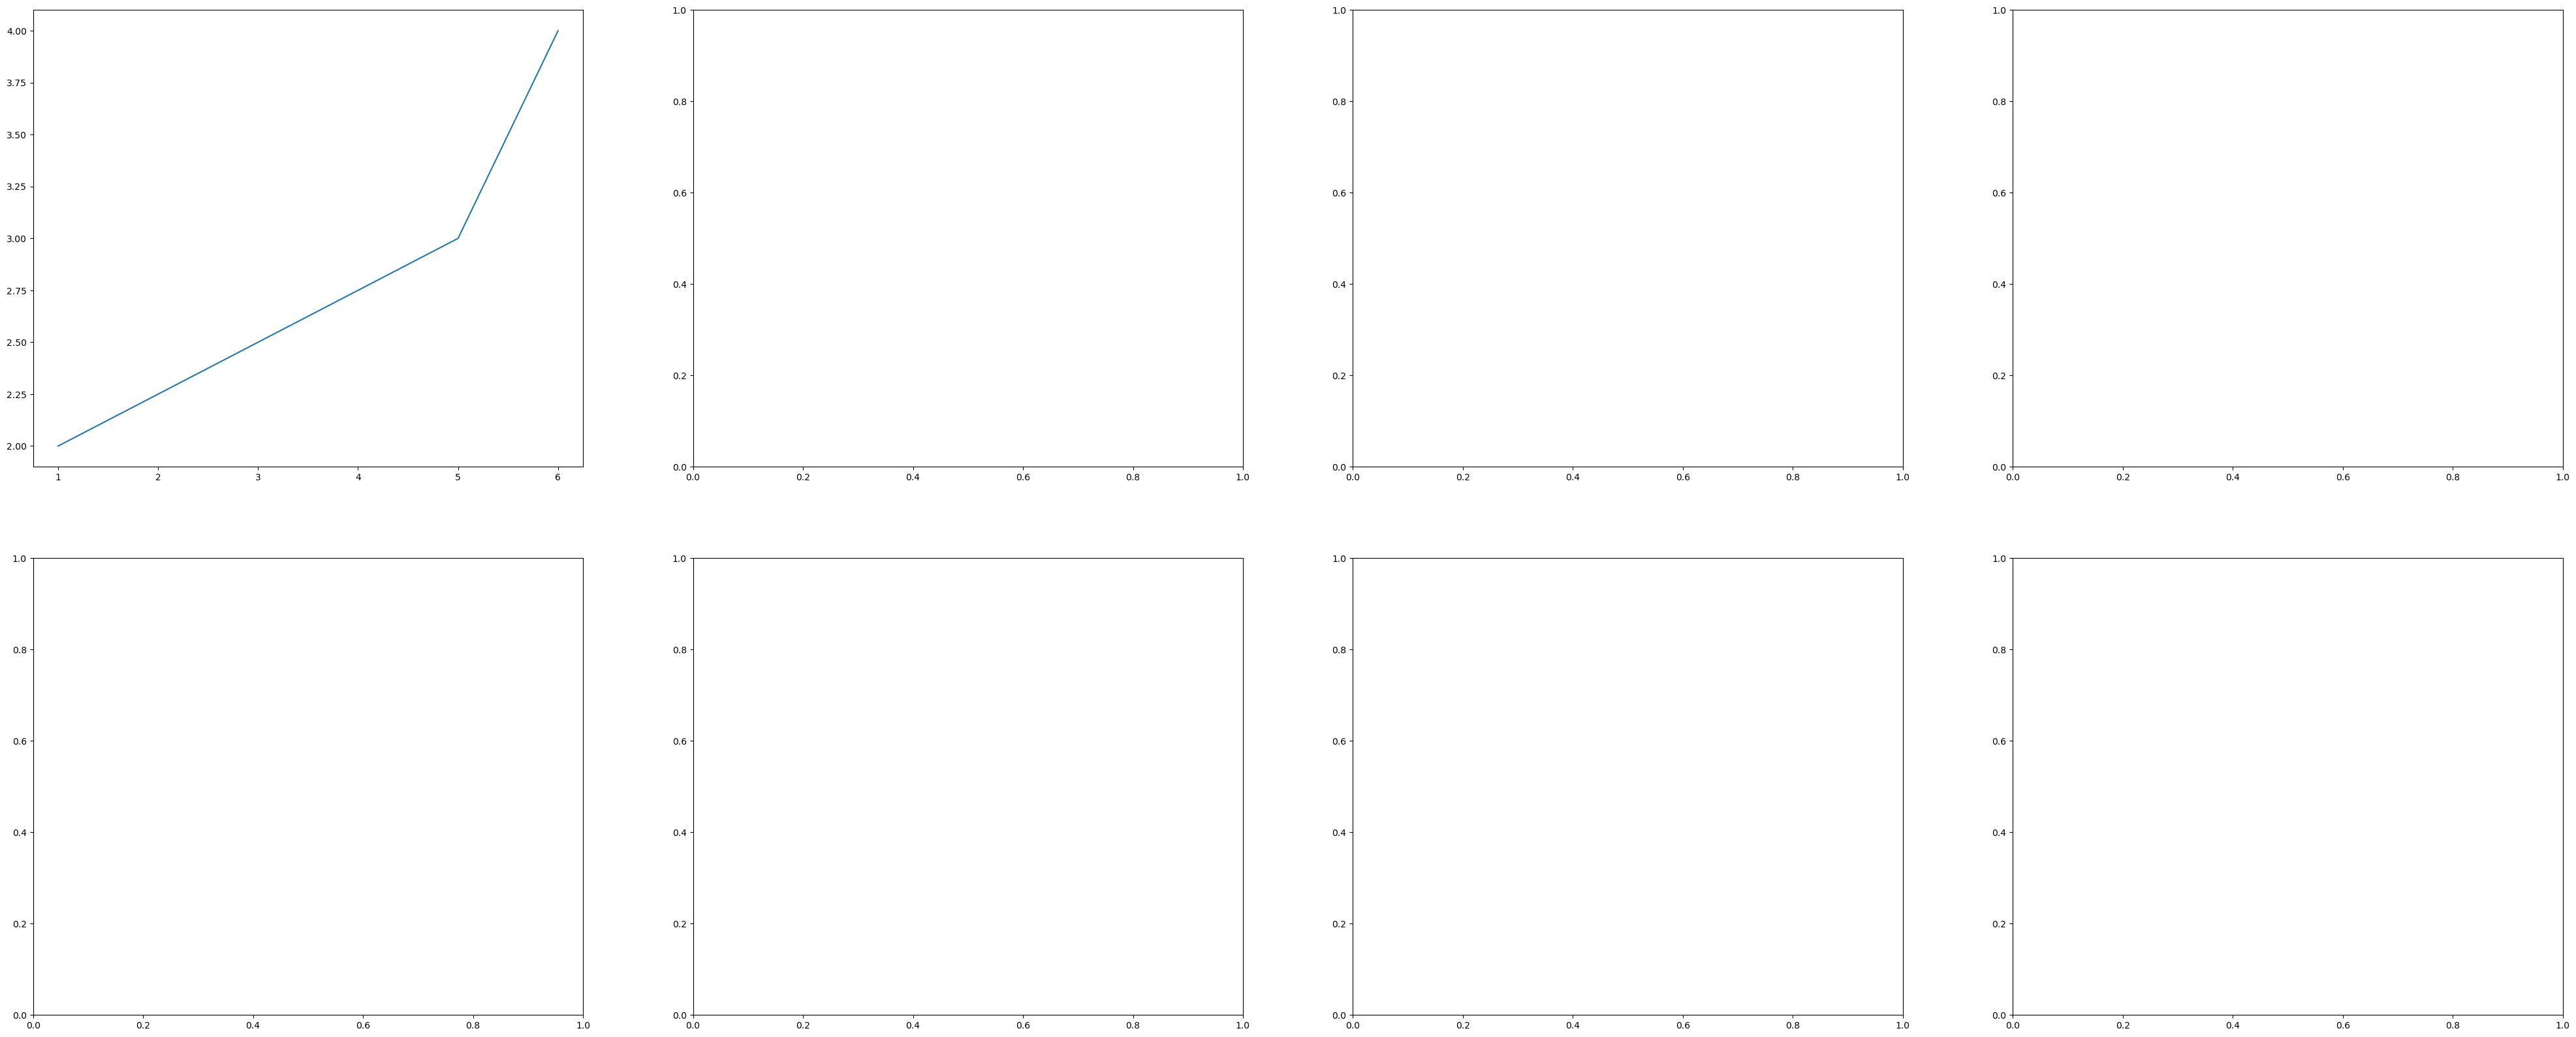

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(50, 20))
for rec in 

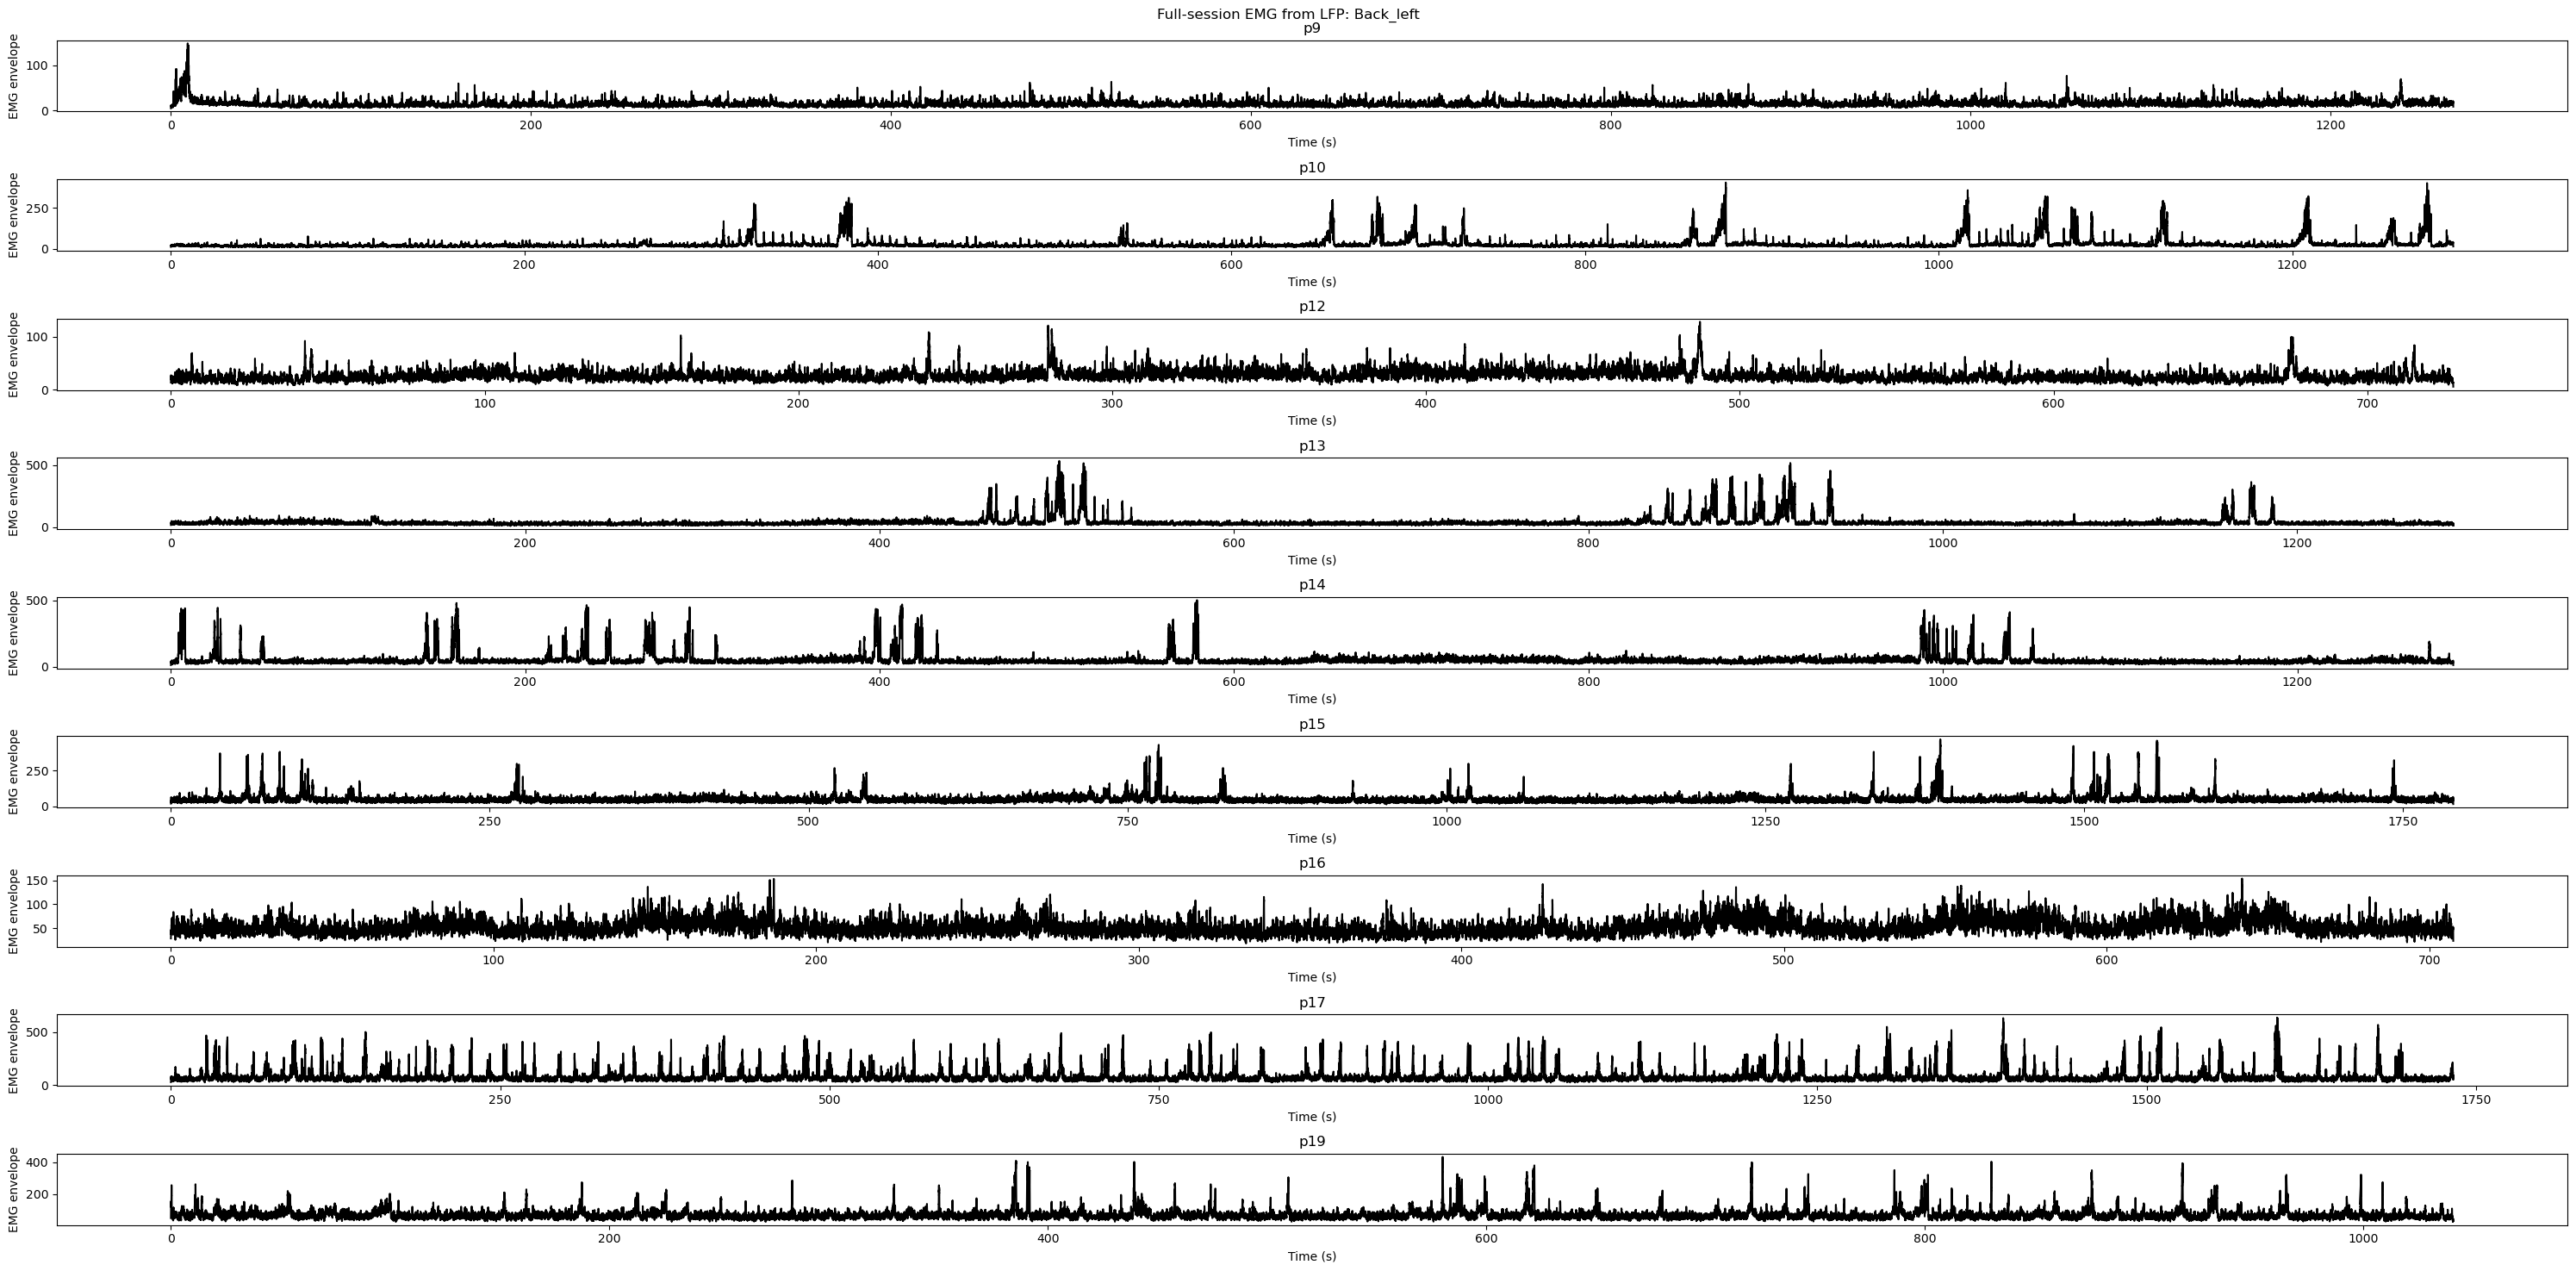

In [136]:
fig, axs = plt.subplots(len(days), 1, figsize=(30, 15))
day_idx = 0
for path in datapaths:
    day = os.path.basename(path)
    lfp_file = f"/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/{animal}/{day}/{day}.lfp"
    n_channels = 1          # or whatever you wrote into the .lfp
    emg_lfp = load_lfp_channel(lfp_file, n_channels=n_channels, ch_idx=0)
    fs = 1250.0             # your LFP sampling rate
    emg_bp, emg_env = emg_envelope_from_lfp(emg_lfp, fs)
    t = np.arange(emg_env.size) / fs
    axs[day_idx].plot(t, emg_env, color='black')
    axs[day_idx].set_xlabel("Time (s)")
    axs[day_idx].set_ylabel("EMG envelope")
    axs[day_idx].set_title(f"{day}")
    day_idx += 1
plt.suptitle(f"Full-session EMG from LFP: {animal}")
plt.tight_layout()
plt.show()


In [105]:
test_1 = f"/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p12/p12.lfp"
test_2 = f"/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_left/p13/p13.lfp"
fs = 1250
test1_lfp = load_lfp_channel(test_1, n_channels=1, ch_idx=0)
test2_lfp = load_lfp_channel(test_2, n_channels=1, ch_idx=0)
emg_bp1, emg_env1 = emg_envelope_from_lfp(test1_lfp, fs, smooth_ms=25)
emg_bp2, emg_env2 = emg_envelope_from_lfp(test2_lfp, fs,  smooth_ms=25)
emg_bp2

array([ -0.06952655,  -5.6919635 , -28.72082478, ...,  -1.42791565,
        14.83062571,  -2.56108342], shape=(1610280,))

In [108]:
# after loading lfp for several channels:
print(np.corrcoef(emg_bp1[:100000], emg_bp2[:100000]))

[[1.         0.00847826]
 [0.00847826 1.        ]]


In [ ]:
import pandas as pd
test_paths = ['/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p10',
              '/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p17']
p10_path, p17_path = test_paths[0], test_paths[1]
p10_dataclass = joblib.load('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p10/p10_dataclass.joblib')
p17_dataclass = joblib.load('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p17/p17_dataclass.joblib')
p10_state_df = pd.read_parquet('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p10/p10_state_df.parquet')
p17_state_df = pd.read_parquet('/mnt/Batista_Lab/Joslyn/Experiments/VIPxTiger/dob_8.3.25/preprocessed/Back_Right/p17/p17_state_df.parquet')


In [ ]:
p10_dataclass.